# Bitcoin Recurrent Neural Network
- Recent 1000
- Long short-term memory(LSTM)


## 1. Settings
### 1) Import required libraries

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from visdom import Visdom
viz = Visdom()

In [2]:
import string
import random
import re
import time, math
from utils2 import *
import matplotlib.pyplot as plt

## 2) Hyperparameter

In [3]:
num_epochs = 5000
hidden_size = 100
output_size=1
batch_size =1
num_layers = 3
lr = 0.002
NUM_STEPS = 500
chunk_len=500
num_layers = 1
recent_num =1000
path = '../data/bitstamp.csv'

In [4]:
# train Parameters
seq_length = 200
sub_seq_length = 150
data_dim = 18
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 101
plot_name = 'LSTM_new_01'

## 2. Data

### 2) Get data

In [5]:
data_raw = data_loading(path)

In [6]:
data_raw[-1]

array([  2.35227598e+04,   2.42228105e+04,   9.98175250e+05,
         1.38100004e+01,   5.27782900e+06,   8.50000024e-01,
         6.78738750e+06,   2.36772000e+05,   2.27242000e+05,
         4.77000008e+01,   3.28761011e+03,   1.28863000e+03,
         1.13500004e+01,   7.38174023e+03,   6.66230011e+00,
         1.09690804e+02,   9.67999995e-01,   8.26722336e+00], dtype=float32)

In [7]:
data = data_raw[-recent_num:,:]

In [8]:
data.shape

(1000, 18)

### 3) Chunk into input & label

In [9]:
def random_chunk():
    start_index = random.randint(0, len(data) - chunk_len)
    end_index = start_index + chunk_len + 1
    return data[start_index:end_index]

print(random_chunk().shape)

(501, 18)


In [10]:
def random_training_set():    
    chunk = random_chunk()
    inp = torch.from_numpy(chunk[:-1])
    target = torch.from_numpy(chunk[1:,-1])
    return Variable(inp).cuda(), Variable(target).cuda()

## 3. Model & Optimizer
### 1) Model

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=num_layers):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.encoder = nn.Linear(input_size, hidden_size)
        self.rnn = nn.GRU(hidden_size,hidden_size,num_layers, 'relu')
        self.decoder = nn.Linear(hidden_size, output_size)
    def forward(self, input, hidden,cell):
        out = self.encoder(input.view(1,-1))
        #out = self.encoder(input)
        out,hidden, = self.rnn(out.view(1,1,-1),hidden)
        out = self.decoder(out.view(batch_size,-1))
        return out,hidden,cell
    def init_hidden(self):
        hidden = Variable(torch.zeros(num_layers,batch_size,hidden_size)).cuda()
        cell = Variable(torch.zeros(num_layers,batch_size,hidden_size)).cuda()
        return hidden,cell
model = RNN(data.shape[1], hidden_size, output_size, num_layers).cuda()

### 2) Loss & Optimizer

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.MSELoss()

### 3) Training

In [13]:
for i in range(num_epochs):
    inp , label = random_training_set()
    hidden,cell = model.init_hidden()
    loss = 0
    optimizer.zero_grad()
    for j in range(chunk_len-1):
        x  = inp[j]
        y_ = label[j]
        y,hidden,cell = model(x,hidden,cell)
        loss += loss_func(y,y_)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(i)
        print("\n",loss/chunk_len,"\n")

0

 Variable containing:
 40.0933
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

100

 Variable containing:
 0.1882
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

200

 Variable containing:
1.00000e-02 *
  7.9775
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

300

 Variable containing:
1.00000e-02 *
  5.4133
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

400

 Variable containing:
1.00000e-02 *
  4.7794
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

500

 Variable containing:
1.00000e-02 *
  4.7543
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

600

 Variable containing:
1.00000e-02 *
  4.0187
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

700

 Variable containing:
1.00000e-02 *
  3.7736
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

800

 Variable containing:
1.00000e-02 *
  3.3220
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

900

 Variable containing:
1.00000e-02 *
  3.3832
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 

1000

 Variable containing:
1.00000e-02 *
  3.8959
[torch.cuda.FloatTen

### 4. Inference

In [14]:
def inference_set():    
    inp = torch.from_numpy(data[:-1])
    target = torch.from_numpy(data[1:,-1])
    return Variable(inp).cuda(), Variable(target).cuda()

In [15]:
aa = data[:-1]
aa.shape

(999, 18)

In [16]:
def inference():
    inp , label = inference_set()
    hidden,cell = model.init_hidden()
    optimizer.zero_grad()
    real=[]
    predict=[]
    for j in range(len(inp)-1):
        x  = inp[j]
        y_ = label[j]
        y,hidden,cell = model(x,hidden,cell)
        #print(y_.cpu().data.numpy()[0])
        real.append(y_.cpu().data.numpy()[0])
        #print(y.cpu().data.numpy()[0][0])
        predict.append(y.cpu().data.numpy()[0][0])
        #predict.np.append(y.cpu())
    return real , predict

In [17]:
real, predict = inference()

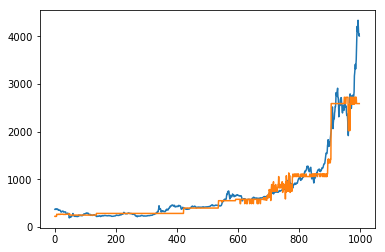

In [18]:
plt.figure
plt.plot(np.exp(real))
plt.plot(np.exp(predict))
plt.show()

In [19]:
real[0:10]

[5.9130974,
 5.9375362,
 5.9298286,
 5.9358988,
 5.9394603,
 5.9371667,
 5.9098206,
 5.9200492,
 5.9260454,
 5.9298549]

In [20]:
predict[0:10]

[5.4061704,
 5.3914399,
 5.3999739,
 5.3999739,
 5.4147043,
 5.3999739,
 5.5890522,
 5.5743217,
 5.5743217,
 5.5743217]

In [21]:
MAPE = np.sum([np.abs((np.exp(real)-np.exp(predict)))/np.exp(predict)])/len(real)

In [22]:
MAPE

0.1462707366637572